# 1. Build dataframe -scraping data from Wikipedia page

In [1]:
import pandas as pd
import numpy as np

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
df = pd.read_html(url)[0]

In [3]:
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### 1.1  Ignore cells with a borough that is Not assigned.

In [4]:
df = df[df["Borough"] != 'Not assigned']
df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


### 1.2 If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough

In [5]:
for index, row in df.iterrows():
  if row['Neighbourhood']== 'Not assigned':
     row['Borough'] = row['Neighbourhood']

In [6]:
df.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights


### 1.3 combine neighbourhood that has the same Postalcode and separate with comma

In [7]:
df_grouped = df.groupby(['Postcode','Borough']).agg(', '.join)
df = df_grouped.reset_index()
df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
df.rename(columns={'Postcode': 'Postal Code'},inplace=True)
df.head()

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [9]:
df.shape

(103, 3)

# 2.Get the latitude and the longitude coordinates of each neighborhood.

### 2.1 Read the geographical coordinates

In [10]:
df_geo = pd.read_csv("https://cocl.us/Geospatial_data")
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### 2.2 Build table of the Neighbourhood and the coordinates

In [11]:
df_geo = pd.merge(df,df_geo,how = 'left',left_on = "Postal Code", right_on = "Postal Code" )
df_geo.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# 3. Explore and cluster the neighborhoods in Toronto

### 3.1 Import liberies

In [12]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

### 3.2 Create a map of Toronto with neighborhoods superimposed on top.

In [13]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="To_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [14]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, Borough, Neighbourhood in zip(df_geo['Latitude'], df_geo['Longitude'], df_geo['Borough'], df_geo['Neighbourhood']):
    label = '{}, {}'.format(Neighbourhood, Borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto


### 3.3 segment and cluster only the neighborhoods in Downtown Toronto

#### a create a new dataframe of the Downtown Toronto  data

In [15]:
downtown_data = df_geo[df_geo['Borough'] == 'Downtown Toronto'].reset_index(drop=True)
downtown_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
1,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
3,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
4,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937


#### b create a map of Downtown Toronto

In [16]:
address = 'Downtown Toronto, ON'

geolocator = Nominatim(user_agent="To_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Downtown Toronto are 43.655115, -79.380219.


In [17]:
# create map of Downtown Toronto using latitude and longitude values
map_DowntownToronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(downtown_data['Latitude'], downtown_data['Longitude'], downtown_data['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_DowntownToronto)  
    
map_DowntownToronto

#### c  utilize the Foursquare API to explore the neighborhoods and segment them.

Define Foursquare Credentials and Version

In [19]:
# The code was removed by Watson Studio for sharing.

Let's explore the first neighborhood in our dataframe.

In [20]:
downtown_data.loc[0, 'Neighbourhood']

'Rosedale'

In [21]:
neighborhood_latitude = downtown_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude =downtown_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = downtown_data.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))
    


Latitude and longitude values of Rosedale are 43.6795626, -79.37752940000001.


Now, let's get the top 100 venues that are in Rosedale within a radius of 500 meters.
First, let's create the GET request URL. Name your URL **url**.

In [22]:
# The code was removed by Watson Studio for sharing.

In [23]:
results = requests.get(url).json()

In [24]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [25]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Mooredale House,Building,43.678631,-79.380091
1,Rosedale Park,Playground,43.682328,-79.378934
2,Whitney Park,Park,43.682036,-79.373788
3,Alex Murray Parkette,Park,43.678300,-79.382773
4,Milkman's Lane,Trail,43.676352,-79.373842


In [26]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

5 venues were returned by Foursquare.


In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)
  

In [28]:
downtown_toronto_venues = getNearbyVenues(names=downtown_data['Neighbourhood'],
                                   latitudes=downtown_data['Latitude'],
                                   longitudes=downtown_data['Longitude']
                                  )

Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie


In [29]:
downtown_toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Mooredale House,43.678631,-79.380091,Building
1,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
2,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
3,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park
4,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail


In [30]:
downtown_toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,58,58,58,58,58,58
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",16,16,16,16,16,16
"Cabbagetown, St. James Town",45,45,45,45,45,45
Central Bay Street,88,88,88,88,88,88
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,15,15,15,15,15,15
Church and Wellesley,86,86,86,86,86,86
"Commerce Court, Victoria Hotel",100,100,100,100,100,100


## 3.4 Analyze Each Neighborhood

In [31]:
# one hot encoding
downtown_toronto_onehot = pd.get_dummies(downtown_toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
downtown_toronto_onehot['Neighbourhood'] = downtown_toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [downtown_toronto_onehot.columns[-1]] + list(downtown_toronto_onehot.columns[:-1])
downtown_toronto_onehot = downtown_toronto_onehot[fixed_columns]

downtown_toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Rosedale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Rosedale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Rosedale,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [32]:
downtown_toronto_onehot.shape

(1299, 206)

In [34]:
downtown_toronto_grouped = downtown_toronto_onehot.groupby('Neighbourhood').mean().reset_index()
downtown_toronto_grouped.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Butcher,Café,Camera Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.040000,0.0,0.0,0.010000,0.010000,0.0,0.03,0.000000,0.0,0.000000,0.010000,0.000000,0.040000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0000,0.010000,0.0000,0.01,0.020000,0.0,0.000000,0.01,0.030000,0.01,0.000000,0.050000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.080000,0.0,0.0,0.0,0.01,0.000000,0.000000,0.020000,0.0,0.020000,0.000000,0.0,0.010000,0.010000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.01,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.01,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.020000,0.0,0.000000,0.01,0.0,0.000000,0.01,0.000000,0.010000,0.000000,0.020000,0.010000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.0,0.010000,0.010000,0.000000,0.010000,0.010000,0.010000,0.000000,0.000000,0.000000,0.0,0.01,0.01,0.000000,0.020000,0.000000,0.0,0.0,0.01,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.01,0.0,0.000000,0.0,0.01,0.01,0.000000,0.01,0.010000,0.01,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.020000,0.000000,0.

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = downtown_toronto_grouped['Neighbourhood']

for ind in np.arange(downtown_toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(downtown_toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,American Restaurant,Thai Restaurant,Hotel,Steakhouse,Asian Restaurant,Sushi Restaurant,Burger Joint
1,Berczy Park,Coffee Shop,Cocktail Bar,Steakhouse,Seafood Restaurant,Beer Bar,Farmers Market,Bakery,Café,Cheese Shop,Irish Pub
2,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Terminal,Airport Lounge,Harbor / Marina,Sculpture Garden,Coffee Shop,Boutique,Boat or Ferry,Airport Gate,Airport Food Court
3,"Cabbagetown, St. James Town",Coffee Shop,Park,Pub,Italian Restaurant,Bakery,Pizza Place,Restaurant,Café,Gift Shop,Beer Store
4,Central Bay Street,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Burger Joint,Ice Cream Shop,Fried Chicken Joint,Salad Place,Bubble Tea Shop,Bar


In [37]:
neighborhoods_venues_sorted.shape

(18, 11)

## 4. Cluster Neighborhoods

In [38]:
downtown_toronto_grouped_clustering = downtown_toronto_grouped.drop('Neighbourhood', 1)

In [39]:
import matplotlib.pyplot as plt

### Find the best k by using Elbow Method

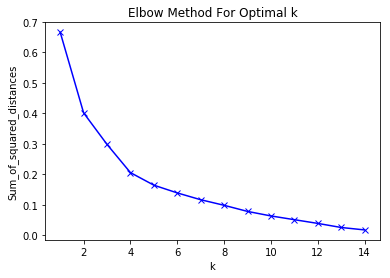

In [40]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(downtown_toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)


plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [41]:
# set number of clusters
kclusters = 4

downtown_toronto_grouped_clustering = downtown_toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(downtown_toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 2, 3, 3, 3, 0, 3, 3, 3], dtype=int32)

In [42]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

downtown_toronto_merged = downtown_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
downtown_toronto_merged = downtown_toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

downtown_toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,1,Park,Playground,Trail,Building,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Dumpling Restaurant,Donut Shop
1,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675,3,Coffee Shop,Park,Pub,Italian Restaurant,Bakery,Pizza Place,Restaurant,Café,Gift Shop,Beer Store
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,3,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Burger Joint,Gay Bar,Gastropub,Men's Store,Mediterranean Restaurant,Hotel
3,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,3,Coffee Shop,Park,Bakery,Café,Restaurant,Pub,Mexican Restaurant,Breakfast Spot,Theater,Greek Restaurant
4,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,3,Coffee Shop,Clothing Store,Cosmetics Shop,Middle Eastern Restaurant,Bakery,Italian Restaurant,Fast Food Restaurant,Café,Ramen Restaurant,Pizza Place


In [43]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.gist_rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downtown_toronto_merged['Latitude'], downtown_toronto_merged['Longitude'], downtown_toronto_merged['Neighbourhood'], downtown_toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine Clusters

#### Cluster 1

In [50]:
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 0, downtown_toronto_merged.columns[[1] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Downtown Toronto,0,Café,Grocery Store,Park,Italian Restaurant,Coffee Shop,Convenience Store,Nightclub,Diner,Baby Store,Restaurant


#### Cluster 2

In [51]:
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 1, downtown_toronto_merged.columns[[1] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,1,Park,Playground,Trail,Building,Dim Sum Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Dumpling Restaurant,Donut Shop


#### Cluster 3

In [52]:
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 2, downtown_toronto_merged.columns[[1] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Downtown Toronto,2,Airport Service,Airport Terminal,Airport Lounge,Harbor / Marina,Sculpture Garden,Coffee Shop,Boutique,Boat or Ferry,Airport Gate,Airport Food Court


#### Cluster 4

In [53]:
downtown_toronto_merged.loc[downtown_toronto_merged['Cluster Labels'] == 3, downtown_toronto_merged.columns[[1] + list(range(5, downtown_toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Downtown Toronto,3,Coffee Shop,Park,Pub,Italian Restaurant,Bakery,Pizza Place,Restaurant,Café,Gift Shop,Beer Store
2,Downtown Toronto,3,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Burger Joint,Gay Bar,Gastropub,Men's Store,Mediterranean Restaurant,Hotel
3,Downtown Toronto,3,Coffee Shop,Park,Bakery,Café,Restaurant,Pub,Mexican Restaurant,Breakfast Spot,Theater,Greek Restaurant
4,Downtown Toronto,3,Coffee Shop,Clothing Store,Cosmetics Shop,Middle Eastern Restaurant,Bakery,Italian Restaurant,Fast Food Restaurant,Café,Ramen Restaurant,Pizza Place
5,Downtown Toronto,3,Coffee Shop,Café,Hotel,Restaurant,Italian Restaurant,Clothing Store,Gastropub,Cosmetics Shop,Bakery,Breakfast Spot
6,Downtown Toronto,3,Coffee Shop,Cocktail Bar,Steakhouse,Seafood Restaurant,Beer Bar,Farmers Market,Bakery,Café,Cheese Shop,Irish Pub
7,Downtown Toronto,3,Coffee Shop,Italian Restaurant,Sandwich Place,Café,Burger Joint,Ice Cream Shop,Fried Chicken Joint,Salad Place,Bubble Tea Shop,Bar
8,Downtown Toronto,3,Coffee Shop,Café,Bar,American Restaurant,Thai Restaurant,Hotel,Steakhouse,Asian Restaurant,Sushi Restaurant,Burger Joint
9,Downtown Toronto,3,Coffee Shop,Aquarium,Hotel,Café,Fried Chicken Joint,Brewery,Scenic Lookout,Italian Restaurant,Restaurant,Sports Bar
10,Downtown Toronto,3,Coffee Shop,Café,Hotel,Italian Restaurant,Restaurant,Seafood Restaurant,Deli / Bodega,Bar,Gastropub,Steakhouse
